<a href="https://colab.research.google.com/github/ybing86-lang/MSSP6070/blob/main/practice_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()

Saving InternetSales (3).csv to InternetSales (3).csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['InternetSales (3).csv']), encoding='latin-1')

/tmp/ipython-input-3916232984.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['InternetSales (3).csv']), encoding='latin-1')


In [5]:
df["OrderDate"] = pd.to_datetime(df["OrderDate"], errors="coerce")
df["SalesAmount"] = pd.to_numeric(df["SalesAmount"], errors="coerce")

In [6]:
monthly_sales = (
    df.dropna(subset=["OrderDate"])
      .set_index("OrderDate")
      .groupby(pd.Grouper(freq="MS"))["SalesAmount"]
      .sum()
      .to_frame("sales")
)
monthly_sales = monthly_sales.asfreq("MS").fillna(0)


In [8]:
monthly_sales["t"] = np.arange(len(monthly_sales))
coef = np.polyfit(monthly_sales["t"], monthly_sales["sales"], 1)
trend = np.poly1d(coef)
last_t = monthly_sales["t"].iloc[-1]
future_t = np.arange(last_t + 1, last_t + 60 + 1)
future_dates = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthBegin(), periods=60, freq="MS")
future_sales = trend(future_t)

In [9]:
forecast = pd.DataFrame({
    "Date": future_dates,
    "Forecast_Sales": np.maximum(future_sales, 0)
})

In [10]:
forecast_yearly = (
    forecast.set_index("Date")
            .resample("YS")["Forecast_Sales"]
            .sum()
            .to_frame("Forecast_Total_Sales")
)
forecast_yearly.index = forecast_yearly.index.year

In [11]:
product_summary = (
    df.groupby("EnglishProductName")["SalesAmount"]
      .agg(["sum", "mean", "count"])
      .rename(columns={"sum": "Total_Sales", "mean": "Avg_Sales", "count": "Records"})
      .sort_values("Total_Sales", ascending=False)
)
top_product = product_summary.head(1)

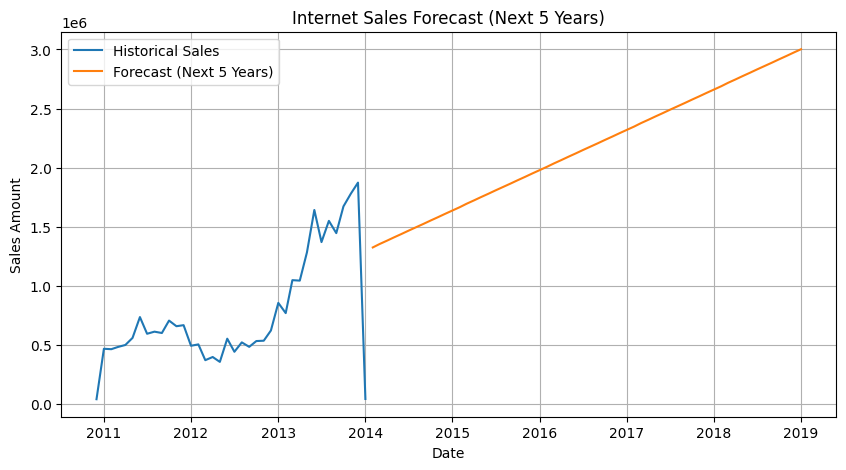

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index, monthly_sales["sales"], label="Historical Sales")
plt.plot(future_dates, future_sales, label="Forecast (Next 5 Years)")
plt.title("Internet Sales Forecast (Next 5 Years)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print("\nTop Product by Total Sales:")
print(top_product)
print("\nYearly Forecast Summary:")
print(forecast_yearly.head(10))


Top Product by Total Sales:
                         Total_Sales    Avg_Sales  Records
EnglishProductName                                        
Mountain-200 Black, 46  1.373470e+06  2215.273465      620

Yearly Forecast Summary:
      Forecast_Total_Sales
Date                      
2014          1.615241e+07
2015          2.154003e+07
2016          2.562965e+07
2017          2.971928e+07
2018          3.380890e+07
2019          3.002009e+06


In [14]:
product_summary.to_csv("/content/product_summary.csv")
forecast.to_csv("/content/forecast_monthly.csv", index=False)
forecast_yearly.to_csv("/content/forecast_yearly.csv")